Loading Data, Imports

In [1]:
# Uncomment to dowload and unzip data
%%capture
%%bash
wget https://www.dropbox.com/s/ormp9hgdyt6kefr/journey-springfield.zip?dl=0 -O journey-springfield.zip 
mkdir data

unzip journey-springfield.zip -d ./data

mv ./data/testset ./data/test
mv ./data/train/simpsons_dataset ./data/
rmdir ./data/train
mv ./data/simpsons_dataset ./data/train

In [2]:
# Check if data exists
![ -d "./data/train" ] && echo "Directory ./data/train exists."
![ -d "./data/test" ] && echo "Directory ./data/testset exists."

Directory ./data/train exists.
Directory ./data/testset exists.


In [3]:
from __future__ import print_function, division
import numpy as np
import time
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models

import matplotlib.pyplot as plt


import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
import time
import os
import copy
import pickle

cudnn.benchmark = True
plt.ion()   # interactive mode

In [4]:
!pip install mlflow --quiet
!pip install pyngrok --quiet

import mlflow
from pyngrok import ngrok

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 75.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.5/83.5 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.1/148.1 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 681.2/681.2 kB 10.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [5]:
# Choose processor
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [6]:
# Define simple transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [7]:
data_dir = './data/'

In [8]:
# Create image datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) \
                  for x in ['train', 'test']}

In [9]:
# Create loaders
BATCH_SIZE = 32
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes


In [10]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    ax.set_title(title)

    return ax

<Axes: title={'center': 'milhouse_van_houten'}>

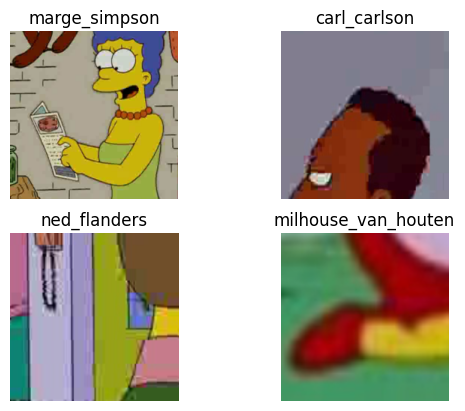

In [11]:
# Run this to test your data loader
images, labels = next(iter(dataloaders['train']))
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2)
imshow(images[0], ax=ax0, normalize=True, title=image_datasets['train'].classes[labels[0]])
imshow(images[1], ax=ax1, normalize=True, title=image_datasets['train'].classes[labels[1]])
imshow(images[2], ax=ax2, normalize=True, title=image_datasets['train'].classes[labels[2]])
imshow(images[3], ax=ax3, normalize=True, title=image_datasets['train'].classes[labels[3]])

In [12]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    param_model_name = str(model_ft.__class__).replace('.', '-')[8:-2]
    with mlflow.start_run(run_name=param_model_name):
        mlflow.log_param('optimizer', param_optimizer)
        mlflow.log_param('lr', param_lr)
        mlflow.log_param('batch_size', param_bs)
        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'test']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0
                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    # print('phase', phase)
                    # print('running corrects', running_corrects)
                    # print('running loss', running_loss)
                if phase == 'train':
                    scheduler.step()
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
                
                # print('epoch loss', epoch_loss)
                # print('epoch acc', epoch_acc)
                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
                
                mlflow.log_metric(f'{phase}_epoch_loss', epoch_loss)
                mlflow.log_metric(f'{phase}_epoch_accuracy', epoch_acc)

                # deep copy the model
                if phase == 'test' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        mlflow.log_metric('best_accuracy', best_acc)
        
        # Dump best weights
        weights_loc = f'./mlruns/models/{param_model_name}.bin'
        with open(weights_loc, 'wb') as f_out:
            pickle.dump(best_model_wts, f_out)
        
        # Log best weights
        mlflow.log_artifact(f'./mlruns/models/{param_model_name}.bin', 'best-weights')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [13]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1

                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
    
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j], ax=ax, title=class_names[preds[j]])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [14]:
LR = 0.1

model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# # Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=LR)

# # Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 73.3MB/s]


In [15]:
# Hyperparameters to log
param_optimizer = str(optimizer_ft.__class__)[8:-2]
param_lr = optimizer_ft.state_dict()['param_groups'][0]['initial_lr']
param_bs = BATCH_SIZE

In [16]:
mlflow.set_experiment('baseline-classifier')     

# run tracking UI in the background
get_ipython().system_raw("mlflow ui --port 5000 &") # run tracking UI in the background

### run here

# create remote tunnel using ngrok.com to allow local port access
# borrowed from https://colab.research.google.com/github/alfozan/MLflow-GBRT-demo/blob/master/MLflow-GBRT-demo.ipynb#scrollTo=4h3bKHMYUIG6


# Terminate open tunnels if exist
ngrok.kill()

# Setting the authtoken (optional)
# Get your authtoken from https://dashboard.ngrok.com/auth
NGROK_AUTH_TOKEN = "2QbvkNkFfJgD1wDiD1gASh53VKq_7PNxKw7RQtSf44Sk6pGUX"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)

2023/06/01 20:15:04 INFO mlflow.tracking.fluent: Experiment with name 'baseline-classifier' does not exist. Creating a new experiment.


MLflow Tracking UI: https://4e52-35-196-168-79.ngrok-free.app


In [17]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                         num_epochs=25)

Epoch 0/24
----------


KeyboardInterrupt: ignored

In [ ]:
visualize_model(model_ft, num_images=6)